# Access GPM IMERG data on glade 

More information on GPM IMERG: https://gpm.nasa.gov/data/imerg

In [113]:
from pathlib import Path 
import h5py
import intake 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr 
import easygems.healpix as egh

### Read in data with catalogue (HEALPix format)

In [2]:
import intake

# Hackathon data catalogs
cat_url = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
cat = intake.open_catalog(cat_url)['online']

dataset = 'IR_IMERG'
zoom_level = 9 
imerg_cat = cat[dataset]
imerg_cat 

IR_IMERG:
  args:
    consolidated: true
    urlpath: https://hackathon-o.s3-ext.jc.rl.ac.uk/obs-data/dev/v1/IR_IMERG_combined/IR_IMERG_combined_V07B.hp_z9.zarr
  description: ''
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: https://digital-earths-global-hackathon.github.io/catalog/online
    creator_email: zhe.feng@pnnl.gov, mark.muetzelfeldt@reading.ac.uk
    creator_name: Zhe Feng, Mark Muetzelfeldt
    history: Obtained and processed by Zhe Feng. Converted to healpix by Mark Muetzelfeldt.
    institution: Pacific Northwest National Laboratory (PNNL)
    time_end: 2022-01-01 00:00:00
    time_start: 2019-01-01 00:00:00
    title: NCEP/CPC 4km Global (60N - 60S) IR and GPM IMERG (precipitation) Dataset


In [115]:
imerg_ds = imerg_cat(zoom = 9, chunks={} ).to_dask().pipe(egh.attach_coords)
imerg_ds

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 1TB
Dimensions:        (time: 52609, cell: 3145728)
Coordinates:
  * time           (time) datetime64[ns] 421kB 2019-01-01 ... 2022-01-01
    crs            int64 8B 0
  * cell           (cell) int64 25MB 0 1 2 3 ... 3145724 3145725 3145726 3145727
    lat            (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon            (cell) float64 25MB 45.0 45.09 44.91 ... 315.1 314.9 315.0
Data variables:
    Tb             (time, cell) float32 662GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    precipitation  (time, cell) float32 662GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
Attributes: (12/21)
    BeginDate:                 2019-01-01
    BeginTime:                 00:00:00.000Z
    EndDate:                   2019-01-01
    EndTime:                   00:59:59.999Z
    FileHeader:                StartGranuleDateTime=2019-01-01T00:00:00.000Z;...
    InputPointer:              merg_2019010100_4km-pixel
    ...                        ...
    nco_openmp_thread_number:  2
    regional:                  True
    remap_hostname:            nid004579
    remap_script:              ncremap
    remap_version:             5.2.4
    title:                     NCEP/CPC 4km Global (60N - 60S) IR Dataset

In [118]:
imerg_precip = imerg_ds.precipitation.sel(time = '2020-07-13T12:00:00.000000000' ).compute()
imerg_precip

<xarray.DataArray 'precipitation' (cell: 3145728)> Size: 13MB
array([0., 0., 0., ..., 0., 0., 0.], shape=(3145728,), dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2020-07-13T12:00:00
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    lat      (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (cell) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
Attributes:
    CodeMissingValue:  -9999.9
    DimensionNames:    time,lon,lat
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...
    Units:             mm/hr
    fullnamepath:      /Grid/precipitation
    long_name:         precipitation
    origname:          precipitation
    units:             mm/hr

### Plot one time snapshot for the IMERG data on HEALPix grid

<Figure size 640x480 with 0 Axes>

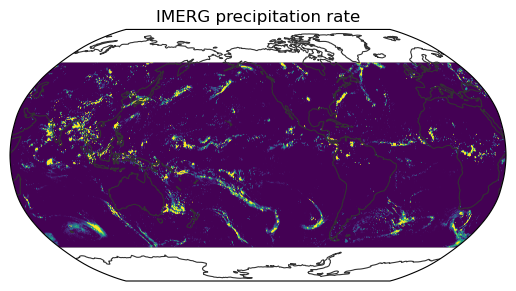

In [136]:
# Create a figure with the desired size
img = egh.healpix_show(imerg_precip, vmax=2)
plt.title("IMERG precipitation rate")
plt.show()

### On glade: Read in files for a specific year and month 

In [90]:
# choose year and month 
year = 2020 
month = 7

gpm_path = Path(str("/glade/campaign/mmm/c3we/prein/observations/GPM_IMERG_V07/"+ str(year) + "/"))

gpm_file_list = list(
    gpm_path.glob(str("3B*IMERG*" + str(year) + str(month).zfill(2) + "*"))
)
gpm_file_list.sort()
print(len(gpm_file_list), "files for GPM found", flush=True)

1488 files for GPM found


### Open file 

In [98]:
fname = gpm_file_list[600]
print(fname)

/glade/campaign/mmm/c3we/prein/observations/GPM_IMERG_V07/2020/3B-HHR.MS.MRG.3IMERG.20200713-S120000-E122959.0720.V07B.HDF5


In [99]:
with h5py.File(fname, "r") as f:
    lat_coords = f["Grid/lat"][:]
    lon_coords = f["Grid/lon"][:]
    precip = f["Grid/precipitation"][:].squeeze()
    precip[precip < 0] = np.nan
    print(np.nanmax(precip))

73.97


In [101]:
# make the data an xarray 
coords = {"lon": lon_coords, "lat": lat_coords}
xarray_data = xr.DataArray(
   precip, coords=coords, dims=["lon", "lat"]
)
xarray_data.max()

<xarray.DataArray ()> Size: 4B
array(73.97, dtype=float32)

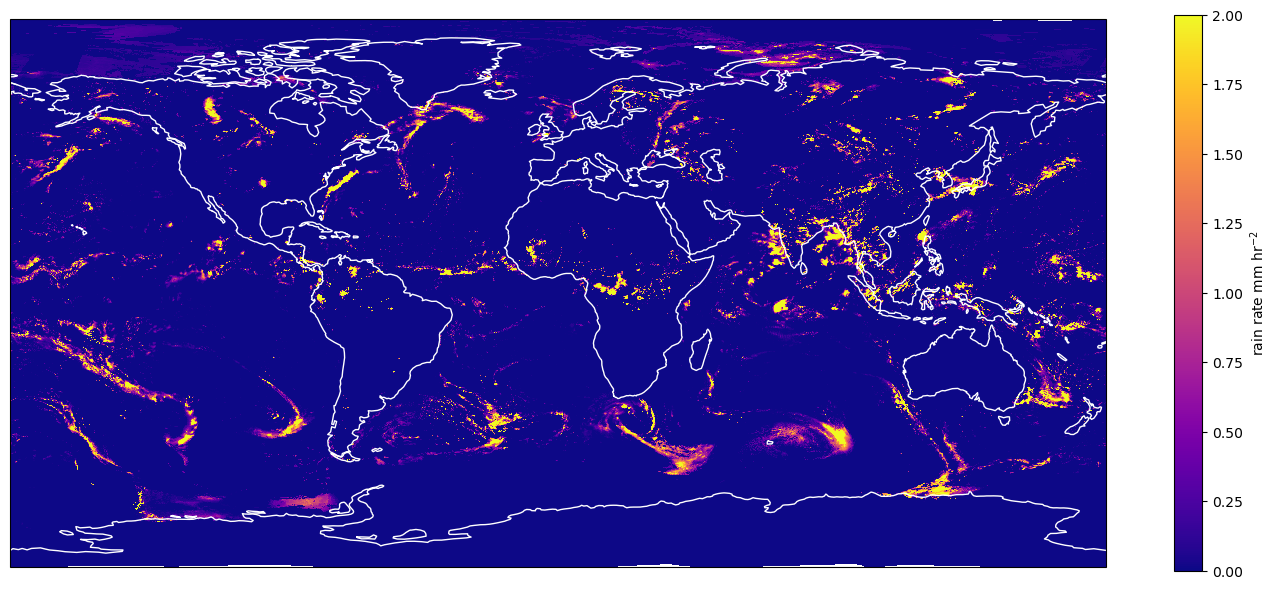

In [124]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

plt.figure(figsize=(14, 6))

# Set up the map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot with coordinate reference system specified
p = ax.pcolormesh(
    lon_coords, lat_coords, precip.T,
    vmin=0, vmax=2, cmap='plasma',
    transform=ccrs.PlateCarree()  # Tell Cartopy what coords your data is in
)

# Add coastlines and other features
ax.coastlines(color = 'white')

# Colorbar
plt.colorbar(p, ax=ax, label='rain rate mm hr$^{-2}$')
plt.tight_layout()
plt.show()


### Regrid data to CONUS404 

In [125]:
def crop_gpm_to_conus(xarray_data, lons, lats):
    """
    Crop GPM IMERG to CONUS extent 

    """
    import numpy as np
    conus_lon_min = -134.02492
    conus_lon_max = -59.963787
    conus_lat_min = 19.80349
    conus_lat_max = 57.837646

    col_start = np.where(lons > conus_lon_min)[0][0]
    col_end = np.where(lons < conus_lon_max)[0][-1]

    row_start = np.where(lats  > conus_lat_min)[0][0]
    row_end = np.where(lats  < conus_lat_max)[0][-1]
    print()

    cropped_gpm = xarray_data[{'lat': slice(row_start, row_end), 'lon': slice(col_start, col_end)}]
    return cropped_gpm

In [126]:
def regrid_to_conus(da, latname, lonname): 
    '''                                                                                            
    Regrids GPM IMERG to CONUS404 grid. 

    da: xr.DataArray to be regridded 
    latname: latitude name 
    lonname: longitude name 

    ''' 
    from scipy.interpolate import griddata
    import numpy as np

    input_lons, input_lats = np.meshgrid(da[lonname].compute().data, da[latname].compute().data)

    # values to regrid as flat array 
    values = da.compute().data.flatten()
    points = np.array([ input_lons.flatten(), input_lats.flatten()]).T

    # target grid: CONUS404 
    conus_data = xr.open_dataset(Path('/glade/campaign/mmm/c3we/CPTP_kukulies/conus404/processed/conus404_201010.nc'))
    target_lons = conus_data.lons.values
    target_lats = conus_data.lats.values
    
    regridded = griddata(points, values, (target_lons, target_lats), method = 'nearest') 
    return regridded 

In [127]:
cropped_gpm = crop_gpm_to_conus(xarray_data, lon_coords, lat_coords)

In [128]:
regridded_precip = regrid_to_conus(cropped_gpm.T ,'lat', 'lon')

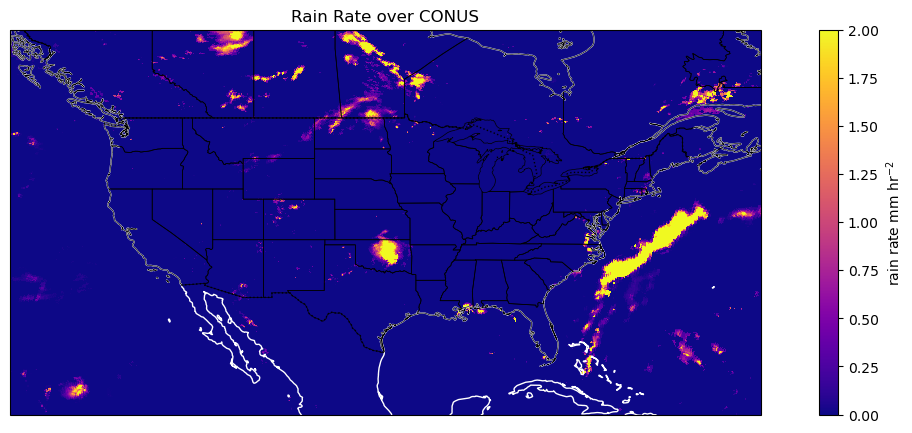

In [129]:
# quick check of the cropped data 

plt.figure(figsize=(15, 5))

ax = plt.axes(projection=ccrs.PlateCarree())

# Plot with coordinate reference system specified
p = ax.pcolormesh(
    cropped_gpm.lon, cropped_gpm.lat, cropped_gpm.T,
    vmin=0, vmax=2, cmap='plasma',
    transform=ccrs.PlateCarree()  
)

# Add coastlines and other features
ax.coastlines(color = 'white')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Colorbar
plt.colorbar(p, ax=ax, label='rain rate mm hr$^{-2}$')
plt.title('Rain Rate over CONUS')

plt.show()

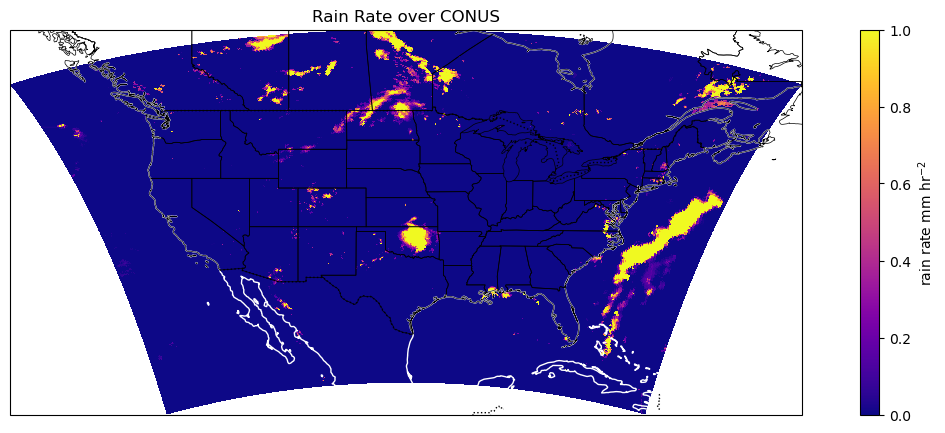

In [130]:
# quick check of the regridded data 

conus_data = xr.open_dataset(Path('/glade/campaign/mmm/c3we/CPTP_kukulies/conus404/processed/conus404_201010.nc'))
target_lons = conus_data.lons.values
target_lats = conus_data.lats.values

plt.figure(figsize=(15, 5))

ax = plt.axes(projection=ccrs.PlateCarree())

# Plot with coordinate reference system specified
p = ax.pcolormesh(
    target_lons, target_lats, regridded_precip,
    vmin=0, vmax=1, cmap='plasma',
    transform=ccrs.PlateCarree()  
)

# Add coastlines and other features
ax.coastlines(color = 'white')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Colorbar
plt.colorbar(p, ax=ax, label='rain rate mm hr$^{-2}$')
plt.title('Rain Rate over CONUS')

plt.show()